# Credit Card Fraud Detection with Autoencoders!

## Problem Statement

## Imports

In [1]:
import pdb
import sys
import os
import time
import pandas as pd
from sklearn.metrics import f1_score
import pathlib
import copy
import pickle
import warnings
from datetime import datetime
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from matplotlib import style
style.use('seaborn')

import cv2

import numpy as np
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
import torch.nn as nn

In [2]:
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
seed = 5
np.random.seed(seed)
torch.manual_seed(seed)

# Getting the Dataset

In [41]:
PATH = pathlib.Path('../input/'); list(PATH.iterdir())

[PosixPath('../input/creditcard.csv')]

In [42]:
list((PATH).iterdir())

[PosixPath('../input/creditcard.csv')]

In [81]:
df = pd.read_csv(list(PATH.iterdir())[0]); df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,0.09,-0.55,-0.62,-0.99,-0.31,1.47,-0.47,0.21,0.03,0.40,0.25,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,-0.17,1.61,1.07,0.49,-0.14,0.64,0.46,-0.11,-0.18,-0.15,-0.07,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,0.21,0.62,0.07,0.72,-0.17,2.35,-2.89,1.11,-0.12,-2.26,0.52,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,-0.05,-0.23,0.18,0.51,-0.29,-0.63,-1.06,-0.68,1.97,-1.23,-0.21,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,0.75,-0.82,0.54,1.35,-1.12,0.18,-0.45,-0.24,-0.04,0.80,0.41,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [82]:
df.shape

(284807, 31)

In [83]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,"284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00"
mean,"94,813.86",0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,"47,488.15",1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,1.09,1.02,1.00,1.00,0.96,0.92,0.88,0.85,0.84,0.81,0.77,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,-24.59,-4.80,-18.68,-5.79,-19.21,-4.50,-14.13,-25.16,-9.50,-7.21,-54.50,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,"54,201.50",-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,-0.54,-0.76,-0.41,-0.65,-0.43,-0.58,-0.47,-0.48,-0.50,-0.46,-0.21,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,"84,692.00",0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,-0.03,0.14,-0.01,0.05,0.05,0.07,-0.07,-0.00,0.00,-0.06,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,"139,320.50",1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.45,0.74,0.62,0.66,0.49,0.65,0.52,0.40,0.50,0.46,0.13,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,"172,792.00",2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,23.75,12.02,7.85,7.13,10.53,8.88,17.32,9.25,5.04,5.59,39.42,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,"25,691.16",1.00


In [84]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [85]:
class_df = df['Class'].value_counts().to_frame().reset_index()
class_df['% of total'] = class_df['Class'] / len(df) * 100
class_df.rename(columns={'index': 'Class', 'Class': 'Count'})

,Class,Count,% of total
0,0,284315,99.83
1,1,492,0.17


In [86]:
# df["Time"] = df["Time"] / (60*60) % 24

In [87]:
hours = df.describe()['Time']['max'] / (60*60)
print(f"This dataset spans {hours:.0f} hours in total")

This dataset spans 48 hours in total


Aggregating the time feature into hours - **JUSTIFY**

In [88]:
df['Day_hrs'] = df['Time'] / (60*60) % 24

In [89]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Day_hrs
count,"284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00","284,807.00"
mean,"94,813.86",0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00,14.54
std,"47,488.15",1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,1.09,1.02,1.00,1.00,0.96,0.92,0.88,0.85,0.84,0.81,0.77,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04,5.85
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,-24.59,-4.80,-18.68,-5.79,-19.21,-4.50,-14.13,-25.16,-9.50,-7.21,-54.50,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00,0.00
25%,"54,201.50",-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,-0.54,-0.76,-0.41,-0.65,-0.43,-0.58,-0.47,-0.48,-0.50,-0.46,-0.21,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00,10.60
50%,"84,692.00",0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,-0.03,0.14,-0.01,0.05,0.05,0.07,-0.07,-0.00,0.00,-0.06,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00,15.01
75%,"139,320.50",1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.45,0.74,0.62,0.66,0.49,0.65,0.52,0.40,0.50,0.46,0.13,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00,19.33
max,"172,792.00",2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,23.75,12.02,7.85,7.13,10.53,8.88,17.32,9.25,5.04,5.59,39.42,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,"25,691.16",1.00,24.00


## Exploratory Data Analysis

Visualise data with t-SNE and/or PCA

In [93]:
n = 1500
normal_smpl = df[df['Class'] == 0].sample(n=n)
fraud_smpl = df[df['Class'] == 1]

smpl = pd.concat((normal_smpl, fraud_smpl), axis=0).sample(frac=1).reset_index(drop=True)
inp = smpl.drop(columns=['Class', 'Time']).values
targ = smpl['Class'].values

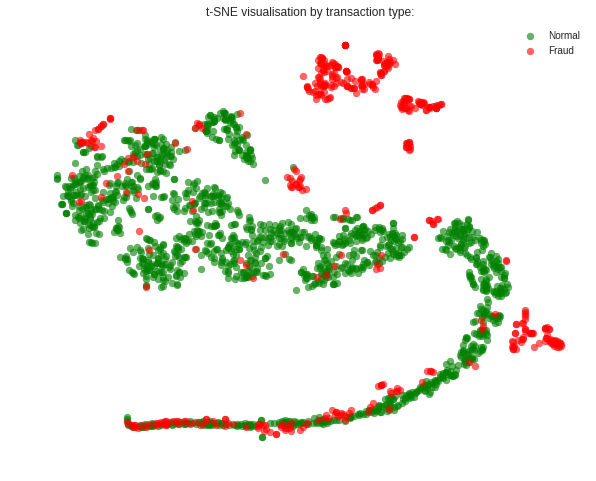

In [94]:
def tsne_plot(inp, targ):
    tsne = TSNE(n_components=2, random_state=seed)
    train = tsne.fit_transform(inp)

    plt.figure(figsize=(10,8))
    plt.title("t-SNE visualisation by transaction type:")
    plt.scatter(train[np.where(targ == 0), 0], train[np.where(targ == 0), 1], marker='o', color='g', alpha=0.6, label="Normal")
    plt.scatter(train[np.where(targ == 1), 0], train[np.where(targ == 1), 1], marker='o', color='r', alpha=0.6, label="Fraud")
    plt.legend(loc='best')
    plt.axis('off')
    plt.show()

tsne_plot(inp, targ)

Some observation clusters seem to be easily seperable but a substantial number remains mixed with [](http://)

Traditional EDA

In [114]:
frauds = fraud_smpl
normal = df[df['Class'] == 0]
data = {
    "Normal": normal,
    "Fraud": frauds
}

Let's check if the amount variable is different:

In [115]:
for t in data: display(t, data[t]['Amount'].describe(), "-"*20)

'Normal'

count   284,315.00
mean         88.29
std         250.11
min           0.00
25%           5.65
50%          22.00
75%          77.05
max      25,691.16
Name: Amount, dtype: float64

'--------------------'

'Fraud'

count     492.00
mean      122.21
std       256.68
min         0.00
25%         1.00
50%         9.25
75%       105.89
max     2,125.87
Name: Amount, dtype: float64

'--------------------'

Mean slightly higher for frauds but not conclusive given the std

Analysis of time:

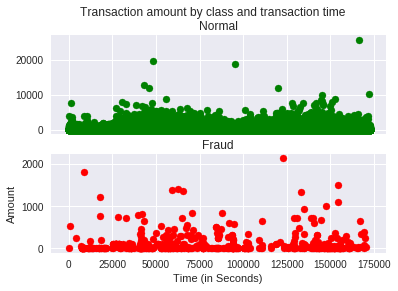

In [129]:
def plot_feature(feat):
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
    fig.suptitle('Transaction amount by class and transaction time')
    for i in (0, 1):
        t = ['Normal', 'Fraud'][i]
        ax[i].scatter(data[t][feat], data[t]['Amount'], color=['g', 'r'][i])
        ax[i].set_title(t)
    plt.xlabel('Time (in Seconds)')
    plt.ylabel('Amount')
    plt.show()

plot_feature('Time')

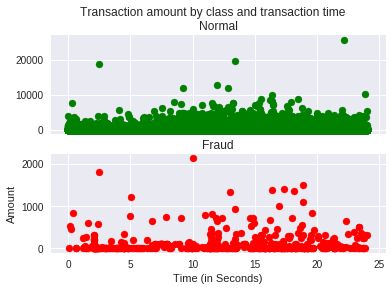

In [131]:
plot_feature('Day_hrs')

# Model - Autoencoder

DATASET DEFINITION:

In [135]:
def activation(act='Tanh'):
    di = {
        'tanh': nn.Tanh(),
        'relu': nn.ReLU(),
        'lrelu': nn.LeakyReLU()
    }
    return di[act]

In [182]:
class AE_layer(nn.Module):
    
    def __init__(self, s_inp, s_out, p, act):
        super().__init__()
        self.s_inp, self.s_out = s_inp, s_out
        self.p, self.act = p, act
        self.layer = nn.Sequential(
            nn.BatchNorm1d(self.s_inp),
            nn.Linear(self.s_inp, self.s_out),
            nn.Dropout(self.p),
#             nn.BatchNorm1d(self.s_out),
            activation(self.act)
        )
    
    def forward(self, x):
        return self.layer(x)

In [183]:
class Autoencoder(nn.Module):
    
    def __init__(self, train, p=0.3):
        super().__init__()
        
        self.inp_sz = train.shape[1]
        self.p = p
        
        self.encoder = nn.Sequential(
            AE_layer(self.inp_sz, 100, p=self.p, act='tanh'),
            AE_layer(100, 50, p=self.p, act='tanh')
        )
        self.latent = nn.Sequential(
            nn.Linear(50, 50),
            nn.LeakyReLU()
        )
        self.decoder = nn.Sequential(
            AE_layer(50, 100, p=self.p, act='tanh'),
            AE_layer(100, self.inp_sz, p=self.p, act='lrelu')
        )
        
        print(self)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.latent(x)
        x = self.decoder(x)
        return x

In [184]:
model = Autoencoder(normal).cuda()

Autoencoder(
  (encoder): Sequential(
    (0): AE_layer(
      (layer): Sequential(
        (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=32, out_features=100, bias=True)
        (2): Dropout(p=0.3)
        (3): Tanh()
      )
    )
    (1): AE_layer(
      (layer): Sequential(
        (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=100, out_features=50, bias=True)
        (2): Dropout(p=0.3)
        (3): Tanh()
      )
    )
  )
  (latent): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): AE_layer(
      (layer): Sequential(
        (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=50, out_features=100, bias=True)
        (2): Dropout(p=0.3)
        (3): Tanh()
      )
    )
    (1

In [185]:
b = torch.cuda.FloatTensor(normal.loc[1:2].values).view(-1, 32)

In [187]:
model(b)

tensor([[ 0.0000e+00, -4.0141e-03, -8.8345e-04,  0.0000e+00,  0.0000e+00,
          6.7511e-01,  1.8252e-01,  0.0000e+00,  0.0000e+00,  4.2549e-01,
         -3.1821e-03,  9.2762e-02, -2.2761e-03,  2.3697e-01, -1.0603e-03,
          9.0060e-01,  0.0000e+00,  6.4424e-01, -6.6930e-03,  0.0000e+00,
          1.9801e-01,  5.3115e-01,  7.9663e-01,  0.0000e+00,  0.0000e+00,
         -4.9409e-03, -5.3255e-04,  5.7654e-02, -6.3636e-03, -3.8684e-03,
         -1.1462e-02,  3.3589e-01],
        [ 0.0000e+00,  0.0000e+00,  6.3912e-02,  2.9299e-01,  0.0000e+00,
         -5.4045e-03,  0.0000e+00, -1.5506e-04,  0.0000e+00, -6.0573e-03,
          5.0717e-01, -1.8533e-03,  0.0000e+00,  0.0000e+00,  2.5028e-01,
          0.0000e+00,  8.7104e-02, -7.5954e-03,  0.0000e+00,  0.0000e+00,
         -4.8015e-03, -2.5572e-03, -5.3651e-03, -1.6855e-03, -1.2898e-02,
          0.0000e+00,  2.8953e-01, -2.5695e-04,  6.7804e-01,  4.4992e-01,
          1.3271e+00, -3.6185e-03]], device='cuda:0',
       grad_fn=<LeakyR

TRAINING LOOP

Classifier based on Autoencoder Error

Classifier based on Autoencoder latent vector

Final stats